# Analyze A/B Test Results


<a id='intro'></a>
## Introduction

A/B tests are very commonly performed by data analysts and data scientists.

<a id='probability'></a>
## Part I - Probability

To get started, let's import our libraries.

In [ ]:
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
%matplotlib inline
#We are setting the seed to assure you get the same answers on quizzes as we set up
random.seed(42)

### ToDo 1.1

**a.** Read in the dataset from the `ab_data.csv` file and take a look at the top few rows here:

In [ ]:
df=pd.read_csv('ab_data.csv')
df.head()

,user_id,timestamp,group,landing_page,converted
0,851104,2017-01-21 22:11:48.556739,control,old_page,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0
4,864975,2017-01-21 01:52:26.210827,control,old_page,1


**b.** Use the cell below to find the number of rows in the dataset.

In [ ]:
df.shape[0]

294478

**c.** The number of unique users in the dataset.

In [ ]:
df['user_id'].nunique()

290584

**d.** The proportion of users converted.

In [ ]:
(df['converted']==1.0).sum()/df.shape[0]

0.11965919355605512

**e.** The number of times when the "group" is `treatment` but "landing_page" is not a `new_page`.

In [ ]:
s1=df.query('landing_page!="new_page"&group=="treatment" ').count()
s2=df.query('landing_page=="new_page"&group!="treatment" ').count()
s1+s2


user_id         3893
timestamp       3893
group           3893
landing_page    3893
converted       3893
dtype: int64

**f.** Do any of the rows have missing values?

In [ ]:
df.isna().sum()

user_id         0
timestamp       0
group           0
landing_page    0
converted       0
dtype: int64

### ToDo 1.2  
In a particular row, the **group** and **landing_page** columns should have either of the following acceptable values:

|user_id| timestamp|group|landing_page|converted|
|---|---|---|---|---|
|XXXX|XXXX|`control`| `old_page`|X |
|XXXX|XXXX|`treatment`|`new_page`|X |


It means, the `control` group users should match with `old_page`; and `treatment` group users should matched with the `new_page`.

However, for the rows where `treatment` does not match with `new_page` or `control` does not match with `old_page`, we cannot be sure if such rows truly received the new or old wepage.  


Use **Quiz 2** in the classroom to figure out how should we handle the rows where the group and landing_page columns don't match?

**a.** Now use the answer to the quiz to create a new dataset that meets the specifications from the quiz.  Store your new dataframe in **df2**.

In [ ]:
# Remove the inaccurate rows, and store the result in a new dataframe df2
df2=df.query('group=="control"&landing_page=="old_page" or group=="treatment"&landing_page=="new_page"')

In [ ]:
# Double Check all of the incorrect rows were removed from df2 -
# Output of the statement below should be 0
df2[((df2['group'] == 'treatment') == (df2['landing_page'] == 'new_page')) == False].shape[0]

0

### ToDo 1.3  
Use **df2** and the cells below to answer questions for **Quiz 3** in the classroom.

**a.** How many unique **user_id**s are in **df2**?

In [ ]:
df2['user_id'].nunique()

290584

**b.** There is one **user_id** repeated in **df2**.  What is it?

In [ ]:
print(df2[df2.duplicated(['user_id'], keep=False)]['user_id'])

1899    773192
2893    773192
Name: user_id, dtype: int64


**c.** Display the rows for the duplicate **user_id**?

In [ ]:
df.iloc[2893]

user_id                             773192
timestamp       2017-01-14 02:55:59.590927
group                            treatment
landing_page                      new_page
converted                                0
Name: 2893, dtype: object

**d.** Remove **one** of the rows with a duplicate **user_id**, from the **df2** dataframe.

In [ ]:
# Remove one of the rows with a duplicate user_id..
# Hint: The dataframe.drop_duplicates() may not work in this case because the rows with duplicate user_id are not entirely identical.
df2=df2.drop(2893)
# Check again if the row with a duplicate user_id is deleted or not
print(df2[df2.duplicated(['user_id'], keep=False)]['user_id'])

Series([], Name: user_id, dtype: int64)


### ToDo 1.4  
Use **df2** in the cells below to answer the quiz questions related to **Quiz 4** in the classroom.

**a.** What is the probability of an individual converting regardless of the page they receive?<br><br>

>**Tip**: The probability  you'll compute represents the overall "converted" success rate in the population and you may call it $p_{population}$.



In [ ]:
(df2['converted']==1).sum()/df2.shape[0]

0.11959708724499628

**b.** Given that an individual was in the `control` group, what is the probability they converted?

In [ ]:
b_old=((df2['converted']==1)&(df2['group']=='control')).sum()/(df2['group']=="control").sum()
b_old

0.1203863045004612

**c.** Given that an individual was in the `treatment` group, what is the probability they converted?

In [ ]:
c_new=((df2['converted']==1)&(df2['group']=='treatment')).sum()/(df2['group']=="treatment").sum()
c_new

0.11880806551510564

In [ ]:
# Calculate the actual difference (obs_diff) between the conversion rates for the two groups.
#(df2['landing_page']=='new_page').sum()/df2.shape[0]
obs_diff=c_new-b_old
obs_diff

-0.0015782389853555567

**d.** What is the probability that an individual received the new page?

In [ ]:
(df2['landing_page']=='new_page').sum()/df2.shape[0]

0.50006194422266881

**e.** Consider your results from parts (a) through (d) above, and explain below whether the new `treatment` group users lead to more conversions.

The old page has better conversion rate than the new page, as The probability of an individual in the treatment group converting and probability of an indiviual in the control group converting are almost the same (0.120 and 0.118)

<a id='ab_test'></a>
## Part II - A/B Test

Since a timestamp is associated with each event, you could run a hypothesis test continuously as long as you observe the events.

However, then the hard questions would be:
- Do you stop as soon as one page is considered significantly better than another or does it need to happen consistently for a certain amount of time?  
- How long do you run to render a decision that neither page is better than another?  

These questions are the difficult parts associated with A/B tests in general.  


### ToDo 2.1
For now, consider you need to make the decision just based on all the data provided.  

> Recall that you just calculated that the "converted" probability (or rate) for the old page is *slightly* higher than that of the new page (ToDo 1.4.c).

If you want to assume that the old page is better unless the new page proves to be definitely better at a Type I error rate of 5%, what should be your null and alternative hypotheses (**$H_0$** and **$H_1$**)?  

You can state your hypothesis in terms of words or in terms of **$p_{old}$** and **$p_{new}$**, which are the "converted" probability (or rate) for the old and new pages respectively.

H0: Pnew<=Pold
H1: Pnew>Pold

### ToDo 2.2 - Null Hypothesis $H_0$ Testing
Under the null hypothesis $H_0$, assume that $p_{new}$ and $p_{old}$ are equal. Furthermore, assume that $p_{new}$ and $p_{old}$ both are equal to the **converted** success rate in the `df2` data regardless of the page. So, our assumption is: <br><br>
<center>
$p_{new}$ = $p_{old}$ = $p_{population}$
</center>

In this section, you will:

- Simulate (bootstrap) sample data set for both groups, and compute the  "converted" probability $p$ for those samples.


- Use a sample size for each group equal to the ones in the `df2` data.


- Compute the difference in the "converted" probability for the two samples above.


- Perform the sampling distribution for the "difference in the converted probability" between the two simulated-samples over 10,000 iterations; and calculate an estimate.



Use the cells below to provide the necessary parts of this simulation.  You can use **Quiz 5** in the classroom to make sure you are on the right track.

**a.** What is the **conversion rate** for $p_{new}$ under the null hypothesis?

In [ ]:
cnv_rate_new=df2['converted'].sum()/df2.shape[0]
cnv_rate_new

0.11959708724499628

**b.** What is the **conversion rate** for $p_{old}$ under the null hypothesis?

In [ ]:
cnv_rate_new

0.11959708724499628

**c.** What is $n_{new}$, the number of individuals in the treatment group? <br><br>

In [ ]:
n_new=(df2['landing_page']=='new_page').sum()
n_new

145310

**d.** What is $n_{old}$, the number of individuals in the control group?

In [ ]:
n_old=(df2['landing_page']=='old_page').sum()
n_old

145274

**e. Simulate Sample for the `treatment` Group**<br>
Simulate $n_{new}$ transactions with a conversion rate of $p_{new}$ under the null hypothesis.  <br><br>
*Hint*: Use `numpy.random.choice()` method to randomly generate $n_{new}$ number of values. <br>
Store these $n_{new}$ 1's and 0's in the `new_page_converted` numpy array.


In [ ]:
# Simulate a Sample for the treatment Group
new_page_converted=np.random.choice([0,1],n_new, p=(cnv_rate_new,1-cnv_rate_new))

**f. Simulate Sample for the `control` Group** <br>
Simulate $n_{old}$ transactions with a conversion rate of $p_{old}$ under the null hypothesis. <br> Store these $n_{old}$ 1's and 0's in the `old_page_converted` numpy array.

In [ ]:
# Simulate a Sample for the control Group
old_page_converted=np.random.choice([0,1],n_old, p=(cnv_rate_new,1-cnv_rate_new))

**g.** Find the difference in the "converted" probability $(p{'}_{new}$ - $p{'}_{old})$ for your simulated samples from the parts (e) and (f) above.

In [ ]:
new_page_converted.mean()-old_page_converted.mean()


-0.0010646975020272009


**h. Sampling distribution** <br>
Re-create `new_page_converted` and `old_page_converted` and find the $(p{'}_{new}$ - $p{'}_{old})$ value 10,000 times using the same simulation process you used in parts (a) through (g) above.

<br>
Store all  $(p{'}_{new}$ - $p{'}_{old})$  values in a NumPy array called `p_diffs`.

In [ ]:
# Sampling distribution
p_diffs=[]
sze=df2.shape[0]
for i in range(10000):
    new_page_converted=np.random.choice([0,1],n_new, p=(cnv_rate_new,1-cnv_rate_new))
    old_page_converted=np.random.choice([0,1],n_old, p=(cnv_rate_new,1-cnv_rate_new))
    diff=new_page_converted.mean() - old_page_converted.mean()
    p_diffs.append(diff)
p_diffs=np.array(p_diffs)

**i. Histogram**<br>
Plot a histogram of the **p_diffs**.  Does this plot look like what you expected?  Use the matching problem in the classroom to assure you fully understand what was computed here.<br><br>

Also, use `plt.axvline()` method to mark the actual difference observed  in the `df2` data (recall `obs_diff`), in the chart.  


(array([   17.,   110.,   591.,  1541.,  2693.,  2608.,  1679.,   607.,
          135.,    19.]),
 array([ -4.34063696e-03,  -3.47273460e-03,  -2.60483223e-03,
         -1.73692986e-03,  -8.69027488e-04,  -1.12511911e-06,
          8.66777250e-04,   1.73467962e-03,   2.60258199e-03,
          3.47048436e-03,   4.33838673e-03]),
 <a list of 10 Patch objects>)

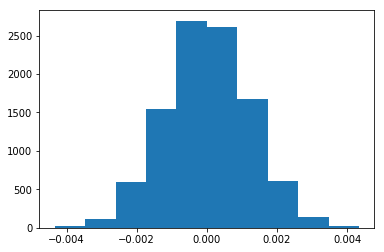

In [ ]:
plt.hist(p_diffs)

**j.** What proportion of the **p_diffs** are greater than the actual difference observed in the `df2` data?

In [ ]:

new_cnv_page=df2[df2['group']=='treatment']['converted'].mean()
old_cnv_page=df2[df2['group']=='control']['converted'].mean()
act_diff=new_cnv_page-old_cnv_page

p_val = (p_diffs>act_diff).mean()
p_val


0.90869999999999995

**k.** Please explain in words what you have just computed in part **j** above.  
 - What is this value called in scientific studies?  
 - What does this value signify in terms of whether or not there is a difference between the new and old pages? *Hint*: Compare the value above with the "Type I error rate (0.05)".

This is the P value, the probability of observing your statistic (or one more extreme in favor of the alternative) if the null hypothesis is true.
we fail to reject the null hypothesis,as the value of p value is large.



**l. Using Built-in Methods for Hypothesis Testing**<br>
We could also use a built-in to achieve similar results.  Though using the built-in might be easier to code, the above portions are a walkthrough of the ideas that are critical to correctly thinking about statistical significance.

Fill in the statements below to calculate the:
- `convert_old`: number of conversions with the old_page
- `convert_new`: number of conversions with the new_page
- `n_old`: number of individuals who were shown the old_page
- `n_new`: number of individuals who were shown the new_page


In [ ]:
import statsmodels.api as sm

# number of conversions with the old_page
convert_old=df2.query('landing_page=="old_page" & converted==1').shape[0]

# number of conversions with the new_page
convert_new=df2.query('landing_page=="new_page" & converted==1').shape[0]

# number of individuals who were shown the old_page
n_old =(df2['landing_page']=='old_page').sum()

# number of individuals who received new_page
n_new =(df2['landing_page']=='new_page').sum()
convert_old,convert_new,n_old,n_new

(17489, 17264, 145274, 145310)

**m.** Now use `sm.stats.proportions_ztest()` to compute your test statistic and p-value.  [Here](https://www.statsmodels.org/stable/generated/statsmodels.stats.proportion.proportions_ztest.html) is a helpful link on using the built in.

The syntax is:
```bash
proportions_ztest(count_array, nobs_array, alternative='larger')
```
where,
- `count_array` = represents the number of "converted" for each group
- `nobs_array` = represents the total number of observations (rows) in each group
- `alternative` = choose one of the values from `[‘two-sided’, ‘smaller’, ‘larger’]` depending upon two-tailed, left-tailed, or right-tailed respectively.


The built-in function above will return the z_score, p_value.

---
### About the two-sample z-test
Recall that you have plotted a distribution `p_diffs` representing the
difference in the "converted" probability  $(p{'}_{new}-p{'}_{old})$  for your two simulated samples 10,000 times.

Another way for comparing the mean of two independent and normal distribution is a **two-sample z-test**. You can perform the Z-test to calculate the Z_score, as shown in the equation below:

$$
Z_{score} = \frac{ (p{'}_{new}-p{'}_{old}) - (p_{new}  -  p_{old})}{ \sqrt{ \frac{\sigma^{2}_{new} }{n_{new}} + \frac{\sigma^{2}_{old} }{n_{old}}  } }
$$

where,
- $p{'}$ is the "converted" success rate in the sample
- $p_{new}$ and $p_{old}$ are the "converted" success rate for the two groups in the population.
- $\sigma_{new}$ and $\sigma_{new}$ are the standard deviation for the two groups in the population.
- $n_{new}$ and $n_{old}$ represent the size of the two groups or samples (it's same in our case)


>Z-test is performed when the sample size is large, and the population variance is known. The z-score represents the distance between the two "converted" success rates in terms of the standard error.

Next step is to make a decision to reject or fail to reject the null hypothesis based on comparing these two values:
- $Z_{score}$
- $Z_{\alpha}$ or $Z_{0.05}$, also known as critical value at 95% confidence interval.  $Z_{0.05}$ is 1.645 for one-tailed tests,  and 1.960 for two-tailed test. You can determine the $Z_{\alpha}$ from the z-table manually.

Decide if your hypothesis is either a two-tailed, left-tailed, or right-tailed test. Accordingly, reject OR fail to reject the  null based on the comparison between $Z_{score}$ and $Z_{\alpha}$. We determine whether or not the $Z_{score}$ lies in the "rejection region" in the distribution. In other words, a "rejection region" is an interval where the null hypothesis is rejected iff the $Z_{score}$ lies in that region.

Reference:
- Example 9.1.2 on this [page](https://stats.libretexts.org/Bookshelves/Introductory_Statistics/Book%3A_Introductory_Statistics_(Shafer_and_Zhang)/09%3A_Two-Sample_Problems/9.01%3A_Comparison_of_Two_Population_Means-_Large_Independent_Samples), courtesy www.stats.libretexts.org

---


In [ ]:
import statsmodels.api as sm
# ToDo: Complete the sm.stats.proportions_ztest() method arguments
z_score, p_value = sm.stats.proportions_ztest(np.array([convert_new, convert_old]), np.array([n_new, n_old]),alternative='larger')
print(z_score, p_value)

-1.31092419842 0.905058312759


**n.** What do the z-score and p-value you computed in the previous question mean for the conversion rates of the old and new pages?  Do they agree with the findings in parts **j.** and **k.**?<br><br>


The p value agrees with J, as it states we fail to reject the null(0189>0.05). The conversion rate for the old page is bigger than or equal to the conversion rate of the new page.
Z score indicates how much a given value differs from the standard deviation,as our Z score is smaller than the critical Z score,then we fail to reject the null

<a id='regression'></a>
### Part III - A regression approach

### ToDo 3.1
In this final part, you will see that the result you achieved in the A/B test in Part II above can also be achieved by performing regression.<br><br>

**a.** Since each row in the `df2` data is either a conversion or no conversion, what type of regression should you be performing in this case?

Logistic Regression

**b.** The goal is to use **statsmodels** library to fit the regression model you specified in part **a.** above to see if there is a significant difference in conversion based on the page-type a customer receives. However, you first need to create the following two columns in the `df2` dataframe:
 1. `intercept` - It should be `1` in the entire column.
 2. `ab_page` - It's a dummy variable column, having a value `1` when an individual receives the **treatment**, otherwise `0`.  

In [ ]:
df2['intercept']=1
df2[['control','ab_page']] = pd.get_dummies(df['group'])
df2.head()

,user_id,timestamp,group,landing_page,converted,intercept,control,ab_page
0,851104,2017-01-21 22:11:48.556739,control,old_page,0,1,1,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0,1,1,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0,1,0,1
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0,1,0,1
4,864975,2017-01-21 01:52:26.210827,control,old_page,1,1,1,0


**c.** Use **statsmodels** to instantiate your regression model on the two columns you created in part (b). above, then fit the model to predict whether or not an individual converts.


In [ ]:
#log_mod = sm.Logit(df2['fraud'], df2[['intercept', 'weekday', 'duration']])
#results = log_mod.fit()
from scipy import stats
stats.chisqprob = lambda chisq, df: stats.chi2.sf(chisq, df)


log_mod=sm.Logit(df2['converted'],df2[['intercept','ab_page']])
results=log_mod.fit()

Optimization terminated successfully.
         Current function value: 0.366118
         Iterations 6


**d.** Provide the summary of your model below, and use it as necessary to answer the following questions.

In [ ]:
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:              converted   No. Observations:               290584
Model:                          Logit   Df Residuals:                   290582
Method:                           MLE   Df Model:                            1
Date:                Wed, 19 Oct 2022   Pseudo R-squ.:               8.077e-06
Time:                        20:23:03   Log-Likelihood:            -1.0639e+05
converged:                       True   LL-Null:                   -1.0639e+05
                                        LLR p-value:                    0.1899
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -1.9888      0.008   -246.669      0.000      -2.005      -1.973
ab_page       -0.0150      0.011     -1.311      0.190      -0.037       0.007
==============================================================================
"""

**e.** What is the p-value associated with **ab_page**? Why does it differ from the value you found in **Part II**?<br><br>  

**Hints**:
- What are the null and alternative hypotheses associated with your regression model, and how do they compare to the null and alternative hypotheses in **Part II**?
- You may comment on if these hypothesis (Part II vs. Part III) are one-sided or two-sided.
- You may also compare the current p-value with the Type I error rate (0.05).


despite that the two P values are differant(0.19 and 0.9), they both bigger than 0.05,which is means the same conclusion that old page is better than or equal new page.

**f.** Now, you are considering other things that might influence whether or not an individual converts.  Discuss why it is a good idea to consider other factors to add into your regression model.  Are there any disadvantages to adding additional terms into your regression model?

It is a good idea to take other factor into account to see whether they could have an impact on the conversion rate, although doing so could make the model more complicated.

**g. Adding countries**<br>
Now along with testing if the conversion rate changes for different pages, also add an effect based on which country a user lives in.

1. You will need to read in the **countries.csv** dataset and merge together your `df2` datasets on the appropriate rows. You call the resulting dataframe `df_merged`. [Here](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.join.html) are the docs for joining tables.

2. Does it appear that country had an impact on conversion?  To answer this question, consider the three unique values, `['UK', 'US', 'CA']`, in the `country` column. Create dummy variables for these country columns.

In [ ]:
# Read the countries.csv
countries_df = pd.read_csv('./countries.csv')

In [ ]:
# Join with the df2 dataframe

df_new = countries_df.set_index('user_id').join(df2.set_index('user_id'), how='inner')

,country,timestamp,group,landing_page,converted,intercept,control,ab_page
user_id,,,,,,,,
834778,UK,2017-01-14 23:08:43.304998,control,old_page,0,1,1,0
928468,US,2017-01-23 14:44:16.387854,treatment,new_page,0,1,0,1
822059,UK,2017-01-16 14:04:14.719771,treatment,new_page,1,1,0,1
711597,UK,2017-01-22 03:14:24.763511,control,old_page,0,1,1,0
710616,UK,2017-01-16 13:14:44.000513,treatment,new_page,0,1,0,1


In [ ]:
# Create the necessary dummy variables
df_new[['CA','US','UK']] = pd.get_dummies(df_new['country'])
logit_mod = sm.Logit(df_new['converted'], df_new[['intercept', 'ab_page', 'CA', 'UK']])
results = logit_mod.fit()
results.summary()

Optimization terminated successfully.
         Current function value: 0.366113
         Iterations 6


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:              converted   No. Observations:               290584
Model:                          Logit   Df Residuals:                   290580
Method:                           MLE   Df Model:                            3
Date:                Wed, 19 Oct 2022   Pseudo R-squ.:               2.323e-05
Time:                        20:26:55   Log-Likelihood:            -1.0639e+05
converged:                       True   LL-Null:                   -1.0639e+05
                                        LLR p-value:                    0.1760
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -1.9794      0.013   -155.415      0.000      -2.004      -1.954
ab_page       -0.0149      0.011     -1.307      0.191      -0.037       0.007
CA            -0.0506      0.028     -1.784      0.074      -0.106       0.005
UK            -0.0099      0.013     -0.743      0.457      -0.036       0.016
==============================================================================
"""

**h. Fit your model and obtain the results**<br>
Though you have now looked at the individual factors of country and page on conversion, we would now like to look at an interaction between page and country to see if are there significant effects on conversion.  **Create the necessary additional columns, and fit the new model.**


Provide the summary results (statistical output), and your conclusions (written response) based on the results.


In [ ]:
# Fit your model, and summarize the results
df_new['UK_ab_page'] = df_new['UK'] * df_new['ab_page']
df_new['CA_ab_page'] = df_new['CA'] * df_new['ab_page']
logit_mod = sm.Logit(df_new['converted'], df_new[['intercept','UK_ab_page', 'CA_ab_page','ab_page', 'CA', 'UK']])
results = logit_mod.fit()
results.summary()

Optimization terminated successfully.
         Current function value: 0.366109
         Iterations 6


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:              converted   No. Observations:               290584
Model:                          Logit   Df Residuals:                   290578
Method:                           MLE   Df Model:                            5
Date:                Wed, 19 Oct 2022   Pseudo R-squ.:               3.482e-05
Time:                        20:29:11   Log-Likelihood:            -1.0639e+05
converged:                       True   LL-Null:                   -1.0639e+05
                                        LLR p-value:                    0.1920
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -1.9922      0.016   -123.457      0.000      -2.024      -1.961
UK_ab_page    -0.0314      0.027     -1.181      0.238      -0.084       0.021
CA_ab_page    -0.0783      0.057     -1.378      0.168      -0.190       0.033
ab_page        0.0108      0.023      0.475      0.635      -0.034       0.056
CA            -0.0118      0.040     -0.296      0.767      -0.090       0.066
UK             0.0057      0.019      0.306      0.760      -0.031       0.043
==============================================================================
"""

As p values for the countries are bigger than the thershold(0.05),that means they aren't significant,then the old page is better than or equal to the

In [ ]:
from subprocess import call
call(['python', '-m', 'nbconvert', 'Analyze_ab_test_results_notebook.ipynb'])

0